In [1]:
%matplotlib notebook

import cantera as ct
import numpy as np
import matplotlib.pyplot as plt

# 0-D Perfectly Stirred Reactor

In this example, we will explore another use of user-defined functions. In Cantera, we can connect several components together to create an open control volume, rather than the closed batch reactor we used to conduct constant U-V simultions previously.

Perfectly stirred reactors are one such example. The PSR is typically a constant volume reaction chamber with a single inlet and outlet to allow flow in and out. In Cantera, we can use several components to control the flow rate in a `Reactor`, including a `Valve`, which calculates the mass flow rate by

$$\dot{m} = K(P_1 - P_2)$$

where $K$ is a constant. Another option is a `MassFlowController`, which sets the mass flow rate to the specified value, regardless of the pressure difference. In this example, we will use a `Valve` between the upstream condition and the reactor, to maintain the reactor at constant pressure; and we will use a `MassFlowController` to control the overall mass flow rate.

In conducting experiments with PSR-analogs, the experimentalists might hold the residence time of the reactants in the reactor constant and vary the inlet conditions (equivalence ratio, temperature, etc.), perhaps to measure the mole fractions of the products coming out of the reactor. Cantera does not have a pre-defined function to set a constant residence time, but we can use a user-defined function to calculate the mass flow rate required to give a certain residence time. Essentially, we will divide the mass of the gas in the reactor by the residence time, and set the mass flow rate through the `MassFlowController` with this function.

The inspiration for this function comes from a post on the User Group: (https://groups.google.com/d/msg/cantera-users/dMUhi5kVVDk/bDFYWMQsgbAJ)

In [2]:
gas = ct.Solution('h2o2.xml')

gas.TPX = 300, ct.one_atm, 'H2:1.0, O2:2.0, AR:4.0'

We need to define some containers for our inlet gas and an area for the exhaust to go to. We will use `Reservoir`s, which are similar to `Reactor`s, except the thermodynamic state in a `Reservoir` is always constant.

In [3]:
upstream = ct.Reservoir(gas)
downstream = ct.Reservoir(gas)

Now we will set the state of the main `Reactor` to the constant enthalpy-pressure equilibrium state. This ensures we start with the steady burning condition.

In [4]:
gas.equilibrate('HP')
r1 = ct.IdealGasReactor(gas)

In [5]:
residence_time = 1.0e-4

def mdot_out(t):
    """
    Compute the mass flow rate for a MassFlowController. The argument
    `t` is the simulation time, so in principle the mass flow rate can
    be computed as a function of time. In this simulation, we don't use
    the time because the mass flow rate will be only a function of the
    reactor mass and (fixed) residence time."""
    return r1.mass / residence_time

Here, we have defined the function we will use to set the mass flow rate. For this example, the residence time is $10^{-4}\ \text{s}$. Next, we define the `Valve` between the `upstream` Reservoir and the reactor, and we give it a constant $K = 100$, so that the inlet mass flow rate very quickly responds to any pressure differences between the upstream and the reactor. We also define a `MassFlowController` on the outlet, and most importantly, we define the mass flow rate of the controller to be computed by the function we defined.

In [6]:
inlet = ct.Valve(upstream, r1, K=100)
outlet = ct.MassFlowController(r1, downstream)
outlet.set_mass_flow_rate(mdot_out)

Now we can create the `ReactorNet` and run the simulation until we approach the steady state. We will assume that steady state occurs after the integration has gone for five residence times, then check afterwards.

In [7]:
net = ct.ReactorNet([r1])
net.set_max_time_step(residence_time)

end_time = 5.0*residence_time
time = []
T = []
mdot = []
while net.time <= end_time:
    time.append(net.time)
    T.append(r1.T)
    mdot.append(outlet.mdot(net.time))
    net.step()

<IPython.core.display.Javascript object>


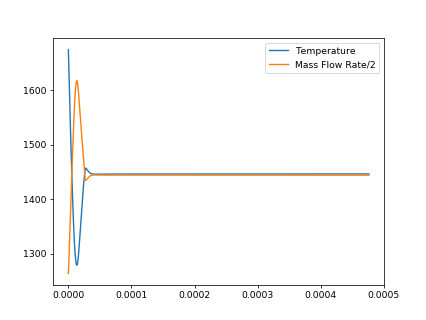

In [8]:
plt.figure()
plt.plot(time, T, label='Temperature')
plt.plot(time, np.array(mdot)/2, label='Mass Flow Rate/2')
plt.legend(loc='best');

From this, we can see that after about 0.1 ms, the solution has already reached steady state.

# Varying Residence Time to Extinction

Another common case to study is changing the residence time until the reactor extinguishes (that is, the steady state solution is the non-reacting solution). We will use the `pandas` library `DataFrame` to store the data for a range of equivalence ratios.

In [9]:
from itertools import product
import pandas as pd

In [10]:
taus = np.logspace(0, -4, num=200)

Here, we define an array of residence times on a logarithmic scale, from $10^0$ to $10^{-4}$ seconds. We choose a `logspace` rather than a `linspace` because the residence time is varying over so many orders of magnitude. Then, we define several pressures and equivalence ratios, and set up the `DataFrame`s.

In [11]:
pres = [1.0]  # Pressure in atmospheres
phis = [0.5, 0.7, 1.0]

index = pd.Index(taus, name="Residence Time")
cols = pd.MultiIndex.from_product([[p for p in pres], [p for p in phis]],
                                  names=['Pressure', 'Phi'])

df_T = pd.DataFrame(index=index, columns=cols, dtype=np.float64)
df_CO = df_T.copy()

Then we define the mass flow rate function and set up the simulation

In [12]:
def mdot(t):
    return reac.mass/res_time

gas = ct.Solution('gri30.xml')
CO_index = gas.species_index('CO')

We will use the built-in `product` function from the `itertools` module to loop over the Cartesian product of the pressures and equivalence ratios. Then, we loop through the residence times, advancing the reactor to steady state for each residence time. Once the steady state reactor temperature has been below 500 K for three residence times in a row, we assume we've reached the extinction point and break out from the loop for that pressure and equivalence ratio.

In [13]:
for p, phi in product(pres, phis):
    print('Pressure:', p, 'Equivalence Ratio:', phi)

    count = 0
    for res_time in taus:
        gas.set_equivalence_ratio(phi, 'CH4', {'O2': 1.0, 'N2': 3.76})
        gas.TP = 300, p*ct.one_atm

        upstream = ct.Reservoir(gas)
        downstream = ct.Reservoir(gas)
        gas.equilibrate('hp')
        reac = ct.IdealGasReactor(gas)
        outlet = ct.MassFlowController(reac, downstream)
        outlet.set_mass_flow_rate(mdot)
        inlet = ct.Valve(upstream, reac, K=100)
        netw = ct.ReactorNet([reac])

        try:
            netw.advance_to_steady_state()
        except ct.CanteraError:
            df_T.loc[res_time, (p, phi)] = np.nan
            df_CO.loc[res_time, (p, phi)] = np.nan
        else:
            df_T.loc[res_time, (p, phi)] = reac.T
            df_CO.loc[res_time, (p, phi)] = gas.X[CO_index]
            if reac.T < 500:
                count += 1
            else:
                count = 0
            if count == 3:
                break


Pressure: 1.0 Equivalence Ratio: 0.5
Pressure: 1.0 Equivalence Ratio: 0.7
Pressure: 1.0 Equivalence Ratio: 1.0


<IPython.core.display.Javascript object>


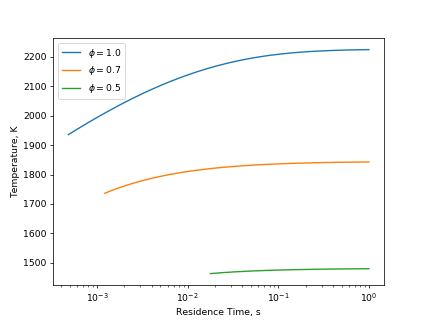

In [14]:
df_T[df_T < 500] = np.nan
plt.figure()
plt.semilogx(df_T.index, df_T[1.0][1.0], label=r'$\phi = 1.0$')
plt.semilogx(df_T.index, df_T[1.0][0.7], label=r'$\phi = 0.7$')
plt.semilogx(df_T.index, df_T[1.0][0.5], label=r'$\phi = 0.5$')
plt.ylabel('Temperature, K')
plt.xlabel('Residence Time, s')
plt.legend(loc='best');

<IPython.core.display.Javascript object>


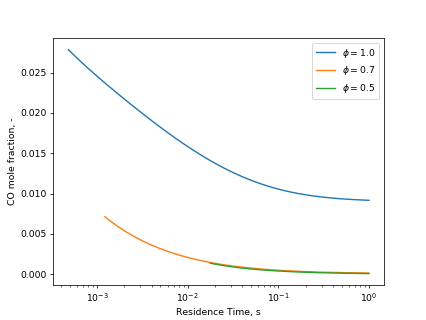

In [15]:
df_CO[df_CO < 1.0E-6] = np.nan
plt.figure()
plt.semilogx(df_CO.index, df_CO[1.0][1.0], label=r'$\phi = 1.0$')
plt.semilogx(df_CO.index, df_CO[1.0][0.7], label=r'$\phi = 0.7$')
plt.semilogx(df_CO.index, df_CO[1.0][0.5], label=r'$\phi = 0.5$')
plt.ylabel('CO mole fraction, -')
plt.xlabel('Residence Time, s')
plt.legend(loc='best');